# Predicting All-NBA Team and Player Salaries - Modeling Part II of II: Player Salaries
---

In our modeling notebooks, we will build upon the groundwork laid by our webscraping, data cleaning, and exploratory data analysis. Our cleaned data now contains over 80 features, including player statistic (advanced, totals, and per-game), salary cap information, and team payroll data. With this, our objective is twofold:

1. _<u>**All-NBA Team**</u>: In our previous notebook ([Part I](./04_Data_Modeling_I.ipynb)), we ..._

    1. _Constructed multiple <u>**regression models**</u> to predict voter share, which ultimately enabled us to discern which Top 15 players made the All-NBA Teams (5 per 1st, 2nd, and 3rd Teams)._ 
    2. _Briefly employed <u>**classification models**</u> to determine how well our models performed in deciphering between 1st, 2nd, and 3rd team players._
    <br></br>
2. <span style = 'color:orange'><u>**Salary**</u>: Next, in this notebook, we will also use <u>**regression modeling**</u> to predict player salaries for the purpose of valuation, training on the intricate relationship between player performance, individual statistics, and their contracts. </span> As such, our target variable may not directly be salary, but rather a normalized representation of salary (given inflation and the fact that contracts have changed drastically in the last 30 years), such as the percent of the salary cap used up by each player. 

This process will involve trial and error as well as the application of GridSearch techniques to fine-tune our models.

At the end of our analysis, we hope to unravel the complexities of the NBA landscape, discovering patterns and associations that govern player recognition in All-NBA Teams and their financial remuneration. These insights will inform decision-making processes and aid in the evaluation of player performance and compensation within the competitive realm of professional basketball.

Further detailed notebooks on the various segments of this project can be found at the following: 
- [01_Data_Acquisition](./01_Data_Acquisition.ipynb)
- [02_Data_Cleaning](./02_Data_Cleaning.ipynb)
- [03_Preliminary_EDA](./03_Preliminary_EDA.ipynb)
- [04_Data_Modeling_I](./04_Data_Modeling_I.ipynb)

For more information on the background, a summary of methods, and findings, please see the associated [README](../README.md) for this analysis.

## Contents
- [Preliminaries](#Preliminaries)
    - [Exploring Target Variable](#Exploring-Target-Variable)
    - [Visualizing Team Salary Changes Over Time](#Visualizing-Team-Salary-Changes-Over-Time)
    - [Null Models](#Null-Model-1)
- [I. Linear Regression](#I.-Linear-Regression)
- [II. Lasso Regression](#II.-Lasso-Regression)
- [III. Ridge Regression](#III.-Ridge-Regression)
- [IV. Support Vector Regression](#IV.-Support-Vector-Regression)
- [V. Elastic Net](#V.-Elastic-Net)
- [VI. Random Forest Regressor](#VI.-Random-Forest-Regressor)
- [VII. AdaBoost Regressor](#VII.-AdaBoost-Regressor)
- [VIII. XGBoost Regressor](#VIII.-XGBoost-Regressor)
- [IX. Light Gradient Boosting](#IX.-Light-Gradient-Boosting)
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import shap
import streamlit as st


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import datetime

import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [2]:
df = pd.read_csv('../data/clean/stats_main.csv')
df.head()

,player,pos,age,tm,g,pg_gs,pg_mp,pg_fg,pg_fga,pg_fg%,pg_3p,pg_3pa,pg_3p%,pg_2p,pg_2pa,pg_2p%,pg_efg%,pg_ft,pg_fta,pg_ft%,pg_orb,pg_drb,pg_trb,pg_ast,pg_stl,pg_blk,pg_tov,pg_pf,pg_pts,year,tot_gs,tot_mp,tot_fg,tot_fga,tot_fg%,tot_3p,tot_3pa,tot_3p%,tot_2p,tot_2pa,tot_2p%,tot_efg%,tot_ft,tot_fta,tot_ft%,tot_orb,tot_drb,tot_trb,tot_ast,tot_stl,tot_blk,tot_tov,tot_pf,tot_pts,adv_per,adv_ts%,adv_3par,adv_ftr,adv_orb%,adv_drb%,adv_trb%,adv_ast%,adv_stl%,adv_blk%,adv_tov%,adv_usg%,adv_ows,adv_dws,adv_ws,adv_ws/48,adv_obpm,adv_dbpm,adv_bpm,adv_vorp,gt1_pos,pos_5,pos_3,f,gu,midseason_trade,all_nba_team,pts_won,pts_max,share,all_nba_winner,draft_year,overall_pick,career_length,n_allstar,all_star,salary,salary_adj,team,conf,div,w,l,w/l%,seed,champs,won_championship,salary_cap,salary_cap_adj,payroll,payroll_adj
0,Nick Anderson,SG,23,ORL,70,42.0,28,5.7,12.2,0.467,0.2,0.8,0.293,5.5,11.4,0.479,0.477,2.5,3.7,0.668,1.3,4.2,5.5,1.5,1.1,0.6,1.6,2.1,14.1,1990,42.0,1971,400.0,857.0,0.467,17.0,58.0,0.293,383.0,799.0,0.479,0.477,173.0,259.0,0.668,92.0,294.0,386.0,106.0,74.0,44.0,113.0,145.0,990.0,15.1,0.510,0.068,0.302,4.9,16.7,10.7,8.5,1.8,1.3,10.4,22.4,1.2,1.9,3.1,0.075,0.0,0.3,0.3,1.1,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,1989.0,11.0,1.0,0.0,0,725000.0,1653775.0,Orlando Magic,W,M,31,51,0.378,19,Chicago Bulls,0,11871000.0,25499592.0,7532000.0,17181014.0
1,Ron Anderson,SF,32,PHI,82,13.0,28,6.2,12.9,0.485,0.1,0.5,0.209,6.1,12.3,0.497,0.490,2.0,2.4,0.833,1.3,3.2,4.5,1.4,0.8,0.2,1.2,2.0,14.6,1990,13.0,2340,512.0,1055.0,0.485,9.0,43.0,0.209,503.0,1012.0,0.497,0.490,165.0,198.0,0.833,103.0,264.0,367.0,115.0,65.0,13.0,100.0,163.0,1198.0,15.5,0.524,0.041,0.188,5.0,12.4,8.8,8.2,1.4,0.3,8.1,23.2,2.3,1.8,4.1,0.085,-0.2,-1.4,-1.6,0.2,0,SF,F,1,0,0,0,0.0,0.0,0.0,0.0,1984.0,27.0,6.0,0.0,0,425000.0,969454.0,Philadelphia 76ers,E,A,44,38,0.537,12,Chicago Bulls,0,11871000.0,25499592.0,11640000.0,26551652.0
2,Willie Anderson,SG,24,SAS,75,75.0,34,6.0,13.2,0.457,0.1,0.5,0.200,5.9,12.7,0.467,0.461,2.3,2.8,0.798,0.9,3.8,4.7,4.8,1.1,0.6,2.2,3.0,14.4,1990,75.0,2592,453.0,991.0,0.457,7.0,35.0,0.200,446.0,956.0,0.467,0.461,170.0,213.0,0.798,68.0,283.0,351.0,358.0,79.0,46.0,167.0,226.0,1083.0,13.0,0.499,0.035,0.215,3.1,11.5,7.5,20.2,1.5,1.1,13.3,20.1,1.3,3.5,4.8,0.089,-0.9,1.0,0.1,1.4,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,1988.0,10.0,2.0,0.0,0,725000.0,1653775.0,San Antonio Spurs,W,M,55,27,0.671,6,Chicago Bulls,0,11871000.0,25499592.0,11057000.0,25221786.0
3,Thurl Bailey,PF,29,UTA,82,22.0,30,4.9,10.6,0.458,0.0,0.0,0.000,4.9,10.6,0.459,0.458,2.7,3.3,0.808,1.2,3.7,5.0,1.5,0.6,1.1,1.6,2.0,12.4,1990,22.0,2486,399.0,872.0,0.458,0.0,3.0,0.000,399.0,869.0,0.459,0.458,219.0,271.0,0.808,101.0,306.0,407.0,124.0,53.0,91.0,130.0,160.0,1017.0,12.5,0.513,0.003,0.311,5.1,13.6,9.6,7.7,1.1,2.3,11.6,20.0,0.6,3.1,3.7,0.072,-1.4,0.0,-1.4,0.4,0,PF,F,1,0,0,0,0.0,0.0,0.0,0.0,1983.0,7.0,7.0,0.0,0,1000000.0,2281070.0,Utah Jazz,W,M,54,28,0.659,7,Chicago Bulls,0,11871000.0,25499592.0,10695000.0,24396040.0
4,Benoit Benjamin,C,26,LAC,70,65.0,31,5.5,11.1,0.496,0.0,0.0,0.000,5.5,11.1,0.496,0.496,3.0,4.2,0.712,2.2,8.1,10.3,1.7,0.8,2.1,3.4,2.6,14.0,1990,65.0,2236,386.0,778.0,0.496,0.0,0.0,0.000,386.0,778.0,0.496,0.496,210.0,295.0,0.712,157.0,566.0,723.0,119.0,54.0,145.0,235.0,184.0,982.0,15.1,0.541,0.000,0.379,7.8,28.7,18.1,7.7,1.2,4.0,20.6,21.0,-0.7,3.7,3.0,0.064,-1.9,0.8,-1.1,0.5,0,C,C,0,0,1,0,0.0,0.0,0.0,0.0,1985.0,3.0,5.0,0.0,0,1750000.0,3991872.0,Los Angeles Clippers,W,P,31,51,0.378,18,Chicago Bulls,0,11871000.0,25499592.0,10245000.0,23369557.0


In [3]:
df.shape

(4372, 105)

## Preliminaries

In [4]:
train_yrs = [i for i in range(1990, 2017)] #1990-2016
test_yrs = [i for i in range(2017,2021)] #2017-2020
hold_yrs = [2021, 2022] 

### Exploring Target Variable

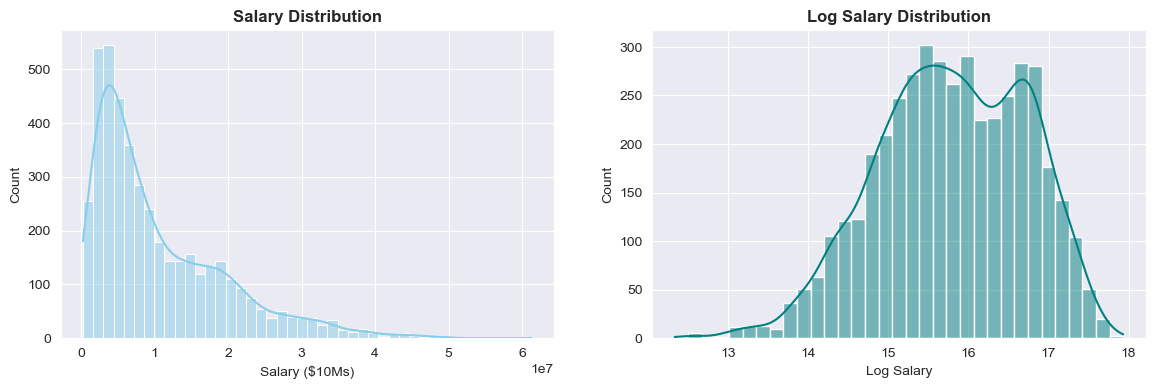

In [5]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.histplot(data=df, x="salary_adj", kde=True, color="skyblue", ax=ax[0]);
ax[0].set_title('Salary Distribution', fontweight='bold')
ax[0].set_xlabel('Salary ($10Ms)')

df['log_sal'] = np.log(df.salary_adj)
sns.histplot(data=df, x="log_sal", kde=True, color="teal", ax=ax[1]);
ax[1].set_title('Log Salary Distribution', fontweight='bold')
ax[1].set_xlabel('Log Salary');

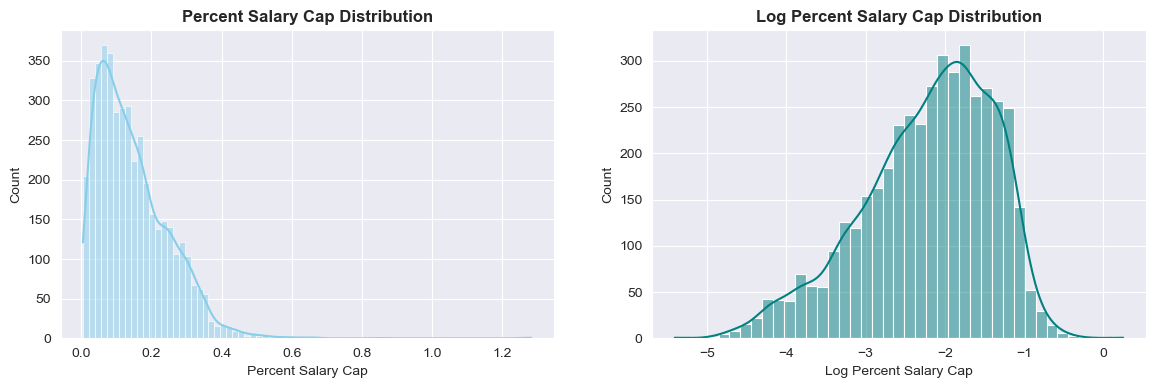

In [6]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
df['pct_cap'] = df.salary_adj / df.salary_cap_adj 
sns.histplot(data=df, x="pct_cap", kde=True, color="skyblue", ax=ax[0]);
ax[0].set_title('Percent Salary Cap Distribution', fontweight='bold')
ax[0].set_xlabel('Percent Salary Cap')

df['pct_cap_log'] = np.log(df.pct_cap)
sns.histplot(data=df, x="pct_cap_log", kde=True, color="teal", ax=ax[1]);
ax[1].set_title('Log Percent Salary Cap Distribution', fontweight='bold')
ax[1].set_xlabel('Log Percent Salary Cap');

##### <span style = 'color:mediumvioletred'> _Player salaries, total and as a percent of the salary cap, are very skewed. Logging the variables becomes slightly more normal. We will quickly test all these are our target variables using linear regression to gauge which ones the model are best at predicting._ </span>

### Visualizing Team Salary Changes Over Time

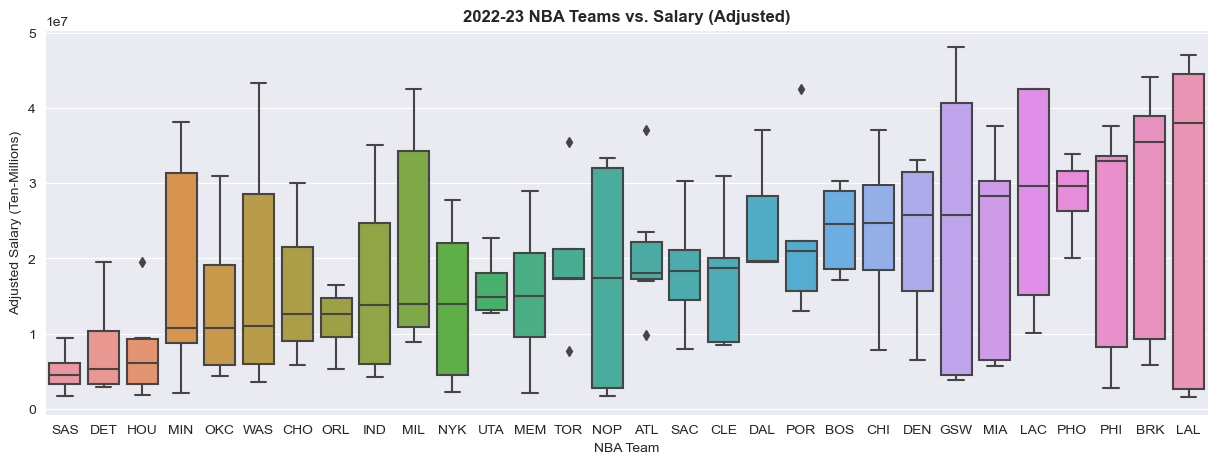

In [7]:
sns.set_style('darkgrid')
              
thirty_yrs = df[df.year == 1992]
twenty_yrs = df[df.year == 2002]
ten_yrs = df[df.year == 2012]
current = df[df.year == 2022]

def tmsals(dyrs, yrs):
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    sorted_teams = dyrs.groupby('tm')['salary_adj'].median().sort_values().index
    sns.boxplot(data=dyrs, x='tm', y='salary_adj', order = sorted_teams)
    
    plt.title(f'{yrs} NBA Teams vs. Salary (Adjusted)', fontweight='bold')
    plt.xlabel('NBA Team')
    plt.ylabel('Adjusted Salary (Ten-Millions)')
    return plt.show()
    
tmsals(current, "2022-23")

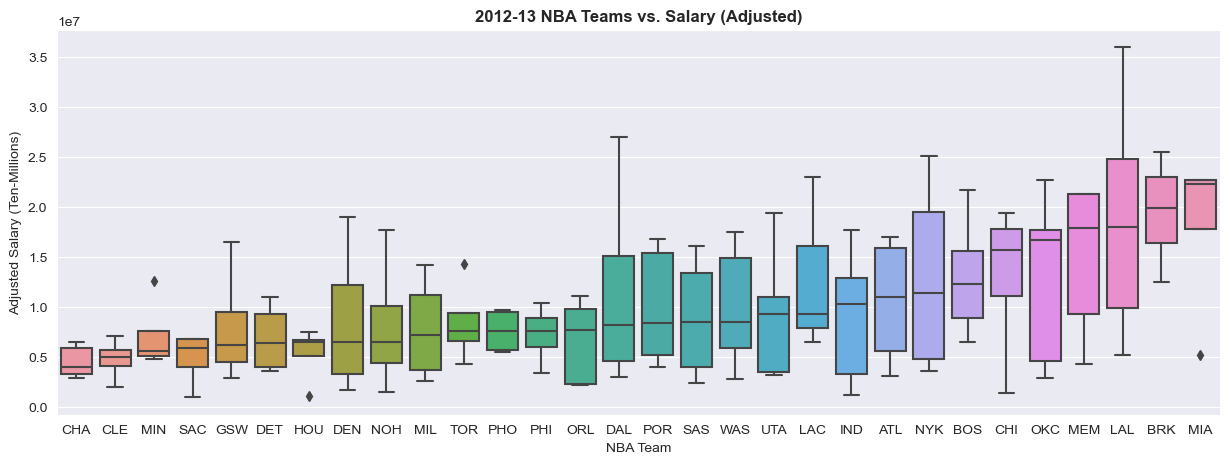

In [8]:
tmsals(ten_yrs, "2012-13")

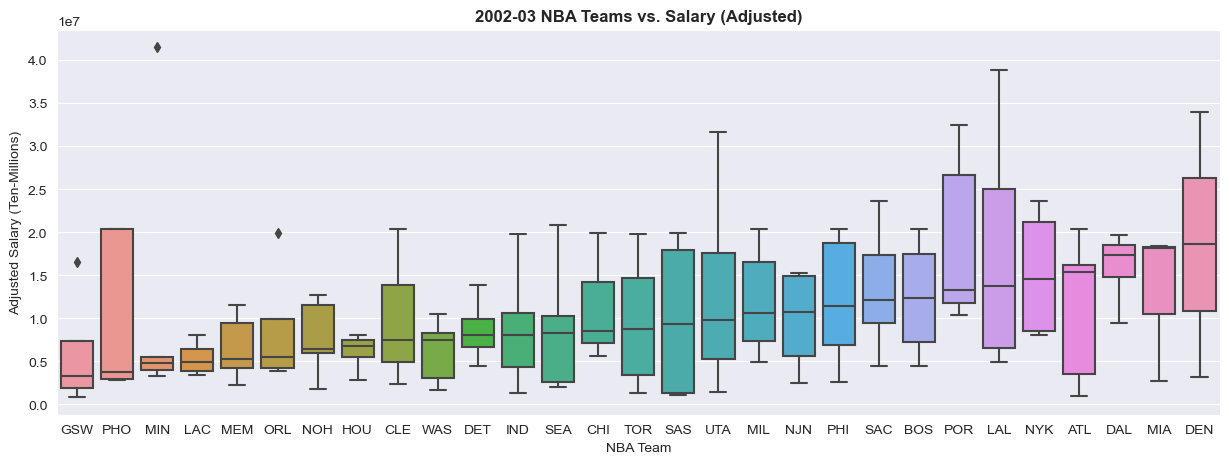

In [9]:
tmsals(twenty_yrs, "2002-03")

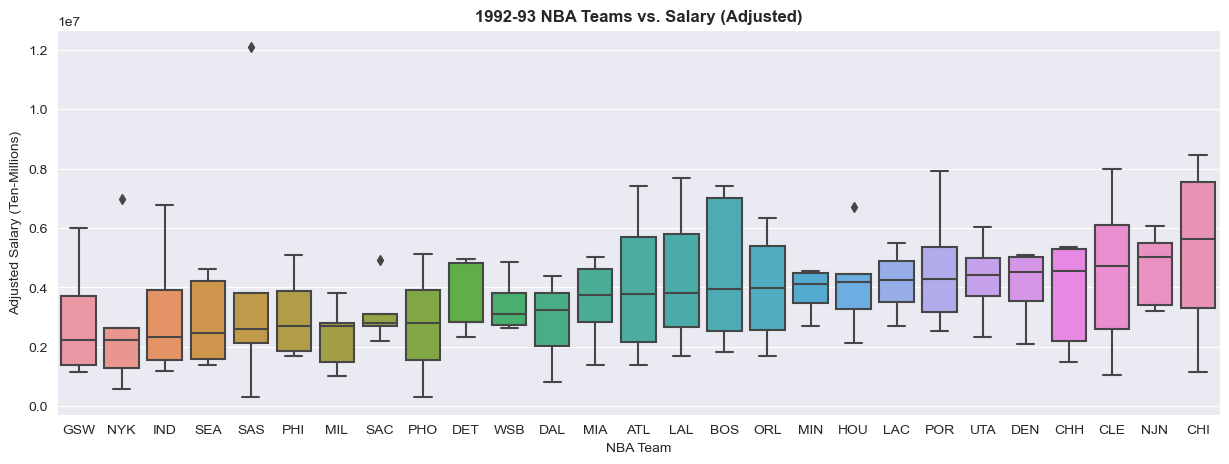

In [10]:
tmsals(thirty_yrs, "1992-93")

##### <span style = 'color:mediumvioletred'> _Salaries are very different today than they were 30 years ago, and team spending varies as well. Generally speaking, the winning teams as well as top contenders seem to have the highest median player salaries year over year,. In the 1992-93 season, Chicago had the highest median salaries, and they were also winners of the championship. In 2002-03, the Lakers had among the highest paid players, Miami had the highest median salaries in the 2012-13 when they were champions, and Oklahoma city (who were also in the finals), were also on the higher end of salary._</span>

In [11]:
# We have dummified Position into 3 Positions for All-NBA voting (G, F, C) - here it is more appropriate to dummify by the standard 5 positions (PG, SG, SF, PF, C)
df = pd.get_dummies(df, columns = ['pos_5'], prefix = 'pos5', drop_first=True)

In [12]:
feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'w/l%', 'seed', 'all_star', 'pos5_PG', 'pos5_SG', 'pos5_SF', 'pos5_PF', 'year', 'salary_cap_adj', 'career_length']

In [13]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)
X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

In [14]:
b1 = "\033[1m"
b0 = "\033[0m"

### Null Model 1

In [15]:
y_train = df['salary_adj'].loc[df.year.isin(train_yrs)]

null_mod = y_train.mean() # Overall mean in training data
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, y_train.mean())

print(f'---- OPTION 1: Predicting Salary ----')
print(f'----- Null Model: {round(null_mod,4)} ------')
print(f'----- Null RMSE: {round(null_mse,4)} -------')
print(f'----------- Null R^2: {round(r2_score(y_train, null_pred),4)} -----------')

---- OPTION 1: Predicting Salary ----
----- Null Model: 9031619.3985 ------
----- Null RMSE: 7317629.9319 -------
----------- Null R^2: 0.0 -----------


### Null Model 2

In [16]:
avg_sal_per_season = df.groupby('year')['salary_adj'].mean().reset_index().rename(columns={'salary_adj': 'mean_salary'})
avg_sal_per_season = avg_sal_per_season.loc[df.year.isin(train_yrs)]                       
                                            
null_mod = avg_sal_per_season.mean_salary.mean() # Mean of mean voter share per season
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, null_mod)

print(f'---- OPTION 2: Predicting Salary Using Salary Per Season ----')
print(f'----------------- Null Model: {round(null_mod,4)} -----------------')
print(f'------------------ Null RMSE: {round(null_mse,4)} ------------------')
print(f'--------------------- Null R^2: {round(r2_score(y_train, null_pred),4)} ---------------------')

---- OPTION 2: Predicting Salary Using Salary Per Season ----
----------------- Null Model: 10522016.2856 -----------------
------------------ Null RMSE: 7467863.8647 ------------------
--------------------- Null R^2: -0.0415 ---------------------


### Null Model 3

In [17]:
y_train = df['pct_cap'].loc[df.year.isin(train_yrs)]

null_mod = y_train.mean() # Overall mean in training data
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, y_train.mean())

print(f'---- OPTION 3: Predicting Cap Share ----')
print(f'---------- Null Model: {round(null_mod,4)} ----------')
print(f'----------- Null RMSE: {round(null_mse,4)} -----------')
print(f'------------- Null R^2: {round(r2_score(y_train, null_pred),4)} ------------')

---- OPTION 3: Predicting Cap Share ----
---------- Null Model: 0.1455 ----------
----------- Null RMSE: 0.104 -----------
------------- Null R^2: 0.0 ------------


In [18]:
avg_pctcap_per_season = df.groupby('year')['pct_cap'].mean().reset_index().rename(columns={'pct_cap': 'mean_pct_cap'})
avg_pctcap_per_season = avg_pctcap_per_season.loc[df.year.isin(train_yrs)]                       
 
null_mod = avg_pctcap_per_season.mean_pct_cap.mean() # Mean of mean voter share per season
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, null_mod)

print(f'---- OPTION 4: Predicting Cap Share Using Cap Share Per Season ----')
print(f'---------- Null Model: {round(null_mod,4)} ----------')
print(f'----------- Null RMSE: {round(null_mse,4)} -----------')
print(f'------------ Null R^2: {round(r2_score(y_train, null_pred),4)} ------------')

---- OPTION 4: Predicting Cap Share Using Cap Share Per Season ----
---------- Null Model: 0.1459 ----------
----------- Null RMSE: 0.104 -----------
------------ Null R^2: -0.0 ------------


##### <span style = 'color:mediumvioletred' > _The null models are very poor at predicting salary. There will likely be a decent amount of variance and nuance in what exactly decides player salary, however, our model will be predicting salary based purely on statistics related to performance, as well as age and general information about the limits of payroll. We will use this to determine over- vs. under-valued players._

---
## I. Linear Regression

In [19]:
# Predicting % Cap
def mod_sal(features, yvar, mod):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    mod.fit(X_train, y_train)
    
    y_preds = mod.predict(X_test)
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, mod.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {mod.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {mod.score(X_train, y_train)}, \n{b1}Testing R2:{b0} {mod.score(X_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
mod_sal(feats, 'pct_cap', LinearRegression())

age: 0.0016998652958395877
g: 0.00011896069558988643
pg_gs: 0.0003127671148530202
pg_mp: 0.0017021004935606511
pg_fg: -0.012600843604626892
pg_fga: 0.04277739410044295
pg_fg%: -0.8270041494212865
pg_3p: 0.02533945088134645
pg_3pa: -0.017660066497469096
pg_3p%: -0.008112360992441727
pg_2p: 0.04263723550581268
pg_2pa: -0.027608786709791142
pg_2p%: 0.05019311108933878
pg_efg%: 0.8594987400773991
pg_ft: -0.01173134954851493
pg_fta: 0.01624405334746466
pg_ft%: 0.02422421396718196
pg_orb: -0.051196209017230904
pg_drb: 0.0081171860545759
pg_trb: 0.009109145700341218
pg_ast: 0.0017102943715595724
pg_stl: -0.01930449329556116
pg_blk: 0.012673439429474022
pg_tov: 0.0022426921049553423
pg_pf: 0.021580012427005225
pg_pts: -0.02320565953960818
tot_mp: 2.474073114940023e-06
tot_fg%: -0.8270041727598687
tot_3p: -0.0001832299634543233
tot_3p%: -0.008112324556613565
tot_2p%: 0.05019309087832746
tot_efg%: 0.8594988544244798
tot_ft%: 0.024224188205735738
tot_pf: -0.0003059459950469634
tot_pts: -1.4473595

In [20]:
# Predicting Adjusted Salary, for comparison
mod_sal(feats, 'salary_adj', LinearRegression())

age: 99104.15986166042
g: -18017.10639621986
pg_gs: 24906.984632476433
pg_mp: 6744.566416180634
pg_fg: 926675.70052568
pg_fga: 2911225.8085268214
pg_fg%: -69905193.7784293
pg_3p: -331158.8861185525
pg_3pa: -627883.4137986159
pg_3p%: -535250.7267858523
pg_2p: 1593844.4053651185
pg_2pa: -2146155.5305987694
pg_2p%: 3258092.664189645
pg_efg%: 84448667.6891775
pg_ft: 418605.2614866741
pg_fta: 496127.33814976364
pg_ft%: 2187580.489112632
pg_orb: -3581769.6203186437
pg_drb: 319843.73589865107
pg_trb: 1090834.4044989962
pg_ast: 246436.0314970225
pg_stl: -1229218.3496459117
pg_blk: -1203615.1361592014
pg_tov: -46448.57293853536
pg_pf: 1370212.8935194896
pg_pts: -1740905.0773850319
tot_mp: 1570.3809830266982
tot_fg%: -69905195.68518053
tot_3p: -8850.872707754374
tot_3p%: -535247.5059563319
tot_2p%: 3258090.5588982375
tot_efg%: 84448679.08751066
tot_ft%: 2187578.0061616683
tot_pf: -18202.56694738567
tot_pts: -2017.845539973583
adv_per: 679879.4685545455
adv_ts%: -69412825.33789954
adv_3par: -2612

In [21]:
# Predicting Log of % Cap
def mod_sal_log(features, yvar, mod):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    mod.fit(X_train, y_train)
    
    y_preds = np.exp(mod.predict(X_test))
    MSE = mean_squared_error(np.exp(y_test), y_preds)
    RMSE = mean_squared_error(np.exp(y_test), y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, np.exp(mod.coef_)):
        print(f"{i}: {coef}")
    print(f"intercept: {np.exp(mod.intercept_)}")
    
    return print(f"\n{b1}Training R2:{b0} {mod.score(X_train, y_train)}, \n{b1}Testing R2:{b0} {mod.score(X_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
mod_sal_log(feats, 'pct_cap_log', LinearRegression())

age: 1.009314573568764
g: 0.9933055501447944
pg_gs: 1.0023982132064222
pg_mp: 1.0119798274491094
pg_fg: 0.9882677714926154
pg_fga: 1.172420975833801
pg_fg%: 0.004209303740672163
pg_3p: 1.0185776537930225
pg_3pa: 0.89349997933439
pg_3p%: 0.9744892124999788
pg_2p: 1.0133492349522284
pg_2pa: 0.8662434762790112
pg_2p%: 1.4888741091400965
pg_efg%: 282.6402037573456
pg_ft: 1.0562699612952204
pg_fta: 0.9028544717900885
pg_ft%: 0.8770108134528409
pg_orb: 0.7095846571362955
pg_drb: 0.9350918775933743
pg_trb: 1.1422560569087583
pg_ast: 1.0380194282670965
pg_stl: 1.0143201923700476
pg_blk: 1.1570463221315421
pg_tov: 1.1625601418233622
pg_pf: 1.1276052686467324
pg_pts: 0.9796828157833162
tot_mp: 1.0001883761748591
tot_fg%: 0.004209303061540707
tot_3p: 0.9985773418828494
tot_3p%: 0.9744894154976168
tot_2p%: 1.4888738313313472
tot_efg%: 282.64043226402
tot_ft%: 0.8770106773178737
tot_pf: 0.9983894893183718
tot_pts: 1.0000163699615956
adv_per: 1.0360311059276108
adv_ts%: 0.012979359766382929
adv_3par

In [22]:
# Predicting Log of Adjusted Salary
mod_sal_log(feats, 'log_sal', LinearRegression())

age: 1.008480904137891
g: 0.9911435618914424
pg_gs: 1.0021515486604848
pg_mp: 1.026296341752881
pg_fg: 0.9972706554660549
pg_fga: 1.2457206569198616
pg_fg%: 0.0036825998602478182
pg_3p: 1.0102712294754082
pg_3pa: 0.8925248714912037
pg_3p%: 0.9742402542058335
pg_2p: 1.0162607629728118
pg_2pa: 0.8696640077459394
pg_2p%: 1.334302678192764
pg_efg%: 272.7023214214676
pg_ft: 1.0373456184054568
pg_fta: 0.9491104642040513
pg_ft%: 0.8491655640436798
pg_orb: 0.6761112170884258
pg_drb: 0.9307040880750821
pg_trb: 1.122035644844369
pg_ast: 0.961102531498919
pg_stl: 0.9756245014280444
pg_blk: 1.0937831652868837
pg_tov: 1.303565290021563
pg_pf: 1.1630281947309187
pg_pts: 0.8947197145183897
tot_mp: 1.000276630875188
tot_fg%: 0.003682599254727376
tot_3p: 0.9990060692850735
tot_3p%: 0.9742404605044089
tot_2p%: 1.3343024238684638
tot_efg%: 272.7025453670186
tot_ft%: 0.8491654305193276
tot_pf: 0.9985701884258118
tot_pts: 0.9998767007708539
adv_per: 1.106369304656471
adv_ts%: 0.01086173513177881
adv_3par: 

##### <span style = 'color:mediumvioletred' > _We have tested linear regression on a few different target variables: the cap share (pct_cap), salary, the log of the cap share (pct_cap_log), and the log of the salary (log_sal). Our models performance did best when predicted cap share (pct_cap). Therefore, going forward we will choose this as our target variable._

---
## II. Lasso Regression

In [23]:
def mod_iteration_lreg(feats, yvar):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    # Scale features
    sc = StandardScaler()
    Z_train = sc.fit_transform(X_train)
    Z_test = sc.transform(X_test)
    
    # Run Lasso Regression
    l_alphas = np.logspace(-5, 0, 150)
    lasso_cv = LassoCV(alphas = l_alphas, cv = 10, max_iter=5_000)
    lasso_cv.fit(Z_train, y_train)
            
    y_preds = lasso_cv.predict(Z_test) # Undoing the logged price
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, lasso_cv.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {lasso_cv.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {lasso_cv.score(Z_train, y_train)}, \n{b1}Testing R2:{b0} {lasso_cv.score(Z_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
mod_iteration_lreg(feats, 'pct_cap')

age: 0.006425180977710961
g: -0.0014794691590411639
pg_gs: 0.0057020946126571355
pg_mp: 0.013020629075071125
pg_fg: 0.0
pg_fga: 0.006093464877784322
pg_fg%: -0.0
pg_3p: -0.0
pg_3pa: -0.0
pg_3p%: -0.0
pg_2p: 0.0
pg_2pa: 0.01689574086005448
pg_2p%: -0.0004375856881100713
pg_efg%: 0.00480014422831109
pg_ft: -0.02948327873850657
pg_fta: 0.012978250477335928
pg_ft%: 0.0
pg_orb: -0.012964661436794806
pg_drb: 0.009596299276114308
pg_trb: 0.0
pg_ast: -0.0
pg_stl: -0.006700058720981735
pg_blk: 0.00817628284867219
pg_tov: 2.8572534263494577e-05
pg_pf: 0.0017035192344518027
pg_pts: -0.0
tot_mp: -0.0
tot_fg%: -0.0
tot_3p: -0.004511707210694349
tot_3p%: -0.0019509064709352588
tot_2p%: -0.001697823298181659
tot_efg%: 0.0
tot_ft%: 0.0
tot_pf: -0.0035267887803346063
tot_pts: -0.00498637212046484
adv_per: 0.0
adv_ts%: -0.019030230720825866
adv_3par: 0.010519544255301834
adv_ftr: 0.016506266755527403
adv_orb%: 0.0
adv_drb%: -0.002640674830980269
adv_trb%: -0.0
adv_ast%: -0.014035244378837217
adv_stl%: -

---
## III. Ridge Regression

In [24]:
def mod_iteration_rreg(feats, yvar):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    # Scale features
    sc = StandardScaler()
    Z_train = sc.fit_transform(X_train)
    Z_test = sc.transform(X_test)

    # Run Ridge Regression
    r_alphas = np.logspace(0, 5, 150)
    ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 10)
    ridge_cv.fit(Z_train, y_train)
            
    y_preds = ridge_cv.predict(Z_test) # Undoing the logged price
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, ridge_cv.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {ridge_cv.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {ridge_cv.score(Z_train, y_train)}, \n{b1}Testing R2:{b0} {ridge_cv.score(Z_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")

mod_iteration_rreg(feats, 'pct_cap')

age: 0.010050388785011268
g: -0.00359564366311243
pg_gs: 0.005391198060706582
pg_mp: 0.009203180946183878
pg_fg: 0.004330489825584851
pg_fga: 0.007250097907397257
pg_fg%: -0.002306319756064181
pg_3p: -9.27116207854199e-05
pg_3pa: 1.8526418064578675e-05
pg_3p%: -0.0010694340688410708
pg_2p: 0.005039088425015929
pg_2pa: 0.006549236582125751
pg_2p%: -0.0017750757291915013
pg_efg%: 0.0028845229654047406
pg_ft: -0.012397039190403998
pg_fta: 0.0033641999183784146
pg_ft%: -0.00195209791946382
pg_orb: -0.008257251442639984
pg_drb: 0.006579605120204954
pg_trb: 0.0018865617536472047
pg_ast: -0.003639204472461101
pg_stl: -0.00617630287801498
pg_blk: 0.005928690405476915
pg_tov: 0.002937067562404194
pg_pf: 0.0024464429500047646
pg_pts: -0.000950809070206757
tot_mp: 0.002402870449192957
tot_fg%: -0.002306319756064187
tot_3p: -0.003589760338680198
tot_3p%: -0.0010694340688410504
tot_2p%: -0.0017750757291915224
tot_efg%: 0.0028845229654046577
tot_ft%: -0.0019520979194637955
tot_pf: -0.004704633940435

In [25]:
# Resetting X and y for the models to follow
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)
X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

y_train = df['pct_cap'].loc[df.year.isin(train_yrs)]
y_test = df['pct_cap'].loc[df.year.isin(test_yrs)]
y_hold = df['pct_cap'].loc[df.year.isin(hold_yrs)]

---
## IV. Support Vector Regression

In [26]:
pipe_svr = Pipeline([
    ('sc', StandardScaler()),
    ('svr', SVR())
])

pipe_svr.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'sc': StandardScaler(),
 'svr': SVR(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [27]:
pgrid_svr =[
    {
     'svr__C': np.linspace(0.0001, 2, 10),
     'svr__kernel': ['linear'], #['rbf', 'poly', 'linear'],
     'svr__degree': [2], #[2, 3, 4],
     'svr__gamma': ['scale'], #['scale','auto'],
     'svr__epsilon': [0.1] #[0.1, 0.5, 1]
    }
]

In [28]:
%%time

gs_svr = GridSearchCV(pipe_svr, pgrid_svr, n_jobs=5)
gs_svr.fit(X_train, y_train)

CPU times: total: 547 ms
Wall time: 56.1 s


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=5,
             param_grid=[{'svr__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svr__degree': [2], 'svr__epsilon': [0.1],
                          'svr__gamma': ['scale'], 'svr__kernel': ['linear']}])

In [29]:
# Make predictions
preds_svr = gs_svr.predict(X_test)

In [30]:
print(f'----------------- {b1}SVR w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svr.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svr.score(X_test, y_test),4)} -------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_svr, squared=False),4)} -------------------')
print('Best Params:', gs_svr.best_params_)

----------------- SVR w/ GridSearch ----------------
------------------ Train: 0.4707 -------------------
------------------- Test: 0.5135 -------------------
------------------- RMSE: 0.0709 -------------------
Best Params: {'svr__C': 0.2223111111111111, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


In [31]:
def residplot(mod, preds):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y_test, preds, s=13, c=['mediumvioletred'])
    ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')
    ax[0].set_title(f'{mod}: True vs. Predicted Voter Share', fontweight='bold')

    residuals = y_test - preds
    ax[1].scatter(y_test, residuals, s=13, c=['mediumvioletred'])
    ax[1].axhline(y=0, color='blue', linestyle='--')
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title(f'{mod}: Voter Share Residual Plot', fontweight='bold')

    plt.tight_layout()
    return plt.show()

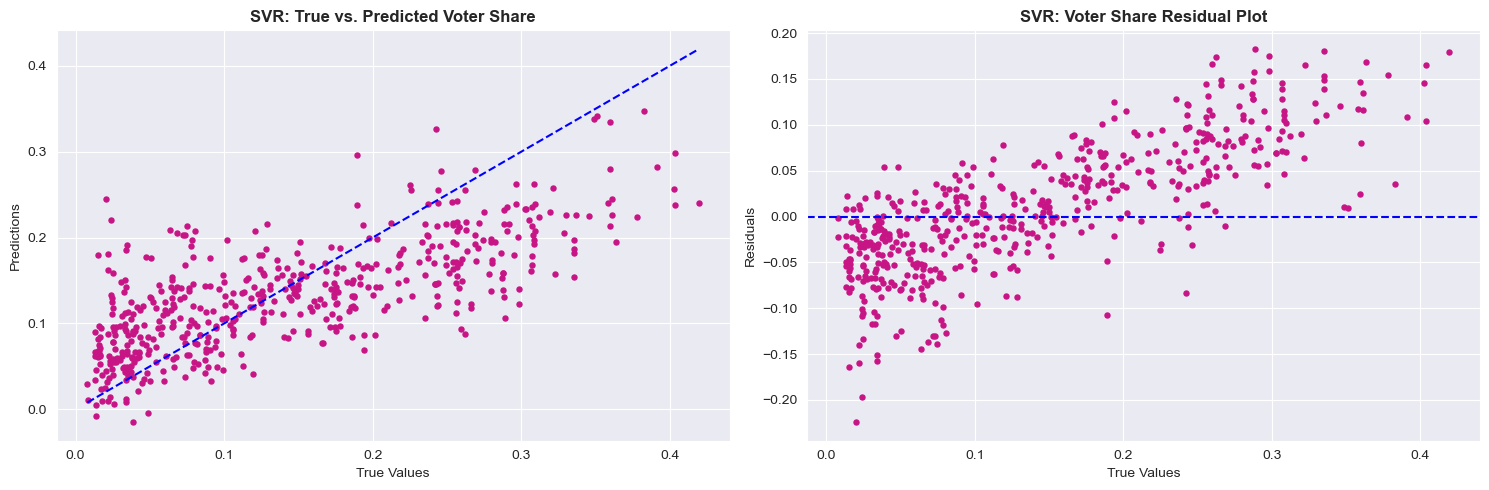

In [32]:
residplot('SVR', preds_svr)

---
## V. Elastic Net

In [33]:
pipe_el = Pipeline([
    ('sc', StandardScaler()),
    ('el', ElasticNet(random_state = 1527))
])

pipe_el.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('el', ElasticNet(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'el': ElasticNet(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'el__alpha': 1.0,
 'el__copy_X': True,
 'el__fit_intercept': True,
 'el__l1_ratio': 0.5,
 'el__max_iter': 1000,
 'el__positive': False,
 'el__precompute': False,
 'el__random_state': 1527,
 'el__selection': 'cyclic',
 'el__tol': 0.0001,
 'el__warm_start': False}

In [34]:
pgrid_el =[
    {'el__alpha': np.linspace(0.01, 10, 10), 
     'el__l1_ratio': np.linspace(0.001, 1, 20),
     'el__max_iter': [1000]
    }]

In [35]:
%%time

gs_el = GridSearchCV(pipe_el, pgrid_el, cv=5, n_jobs=10)
gs_el.fit(X_train, y_train)

CPU times: total: 5.25 s
Wall time: 18.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('el', ElasticNet(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'el__alpha': array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ]),
                          'el__l1_ratio': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ]),
                          'el__max_iter': [1000]}])

In [36]:
preds_el = gs_el.predict(X_test)

In [37]:
print(f'-------------- {b1}Elastic Net w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_el.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_el.score(X_test, y_test),4)} ---------------------')
print(f'-------------------- RMSE: {round(mean_squared_error(y_test, preds_el, squared=False),4)} ---------------------')
print('Best Params:', gs_el.best_params_)

-------------- Elastic Net w/ GridSearch -------------
------------------- Train: 0.4895 --------------------
------------------- Test: 0.5426 ---------------------
-------------------- RMSE: 0.0688 ---------------------
Best Params: {'el__alpha': 0.01, 'el__l1_ratio': 0.001, 'el__max_iter': 1000}


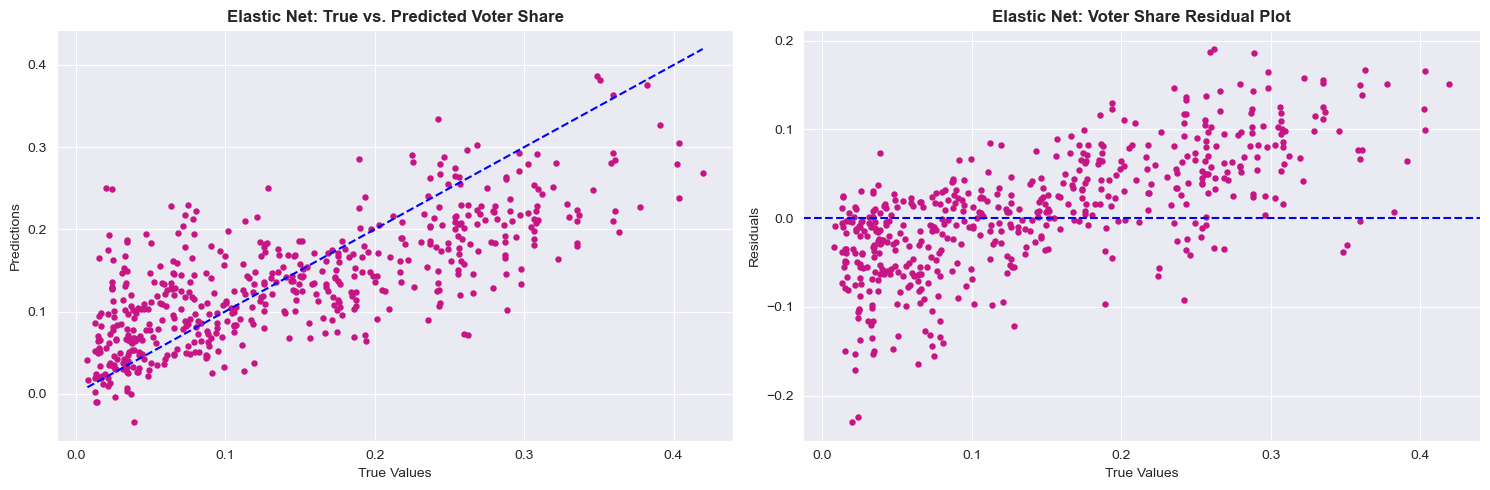

In [38]:
residplot('Elastic Net', preds_el)

In [39]:
best_el = gs_el.best_estimator_
feature_importances = best_el.named_steps['el'].coef_

In [40]:
feature_names = X_train.columns.tolist()

In [41]:
f1 = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
f1.sort_values(by=['feature_importance'], ascending=False,inplace=True)
f12 = f1.reset_index().drop(columns = ['index']).head(30)

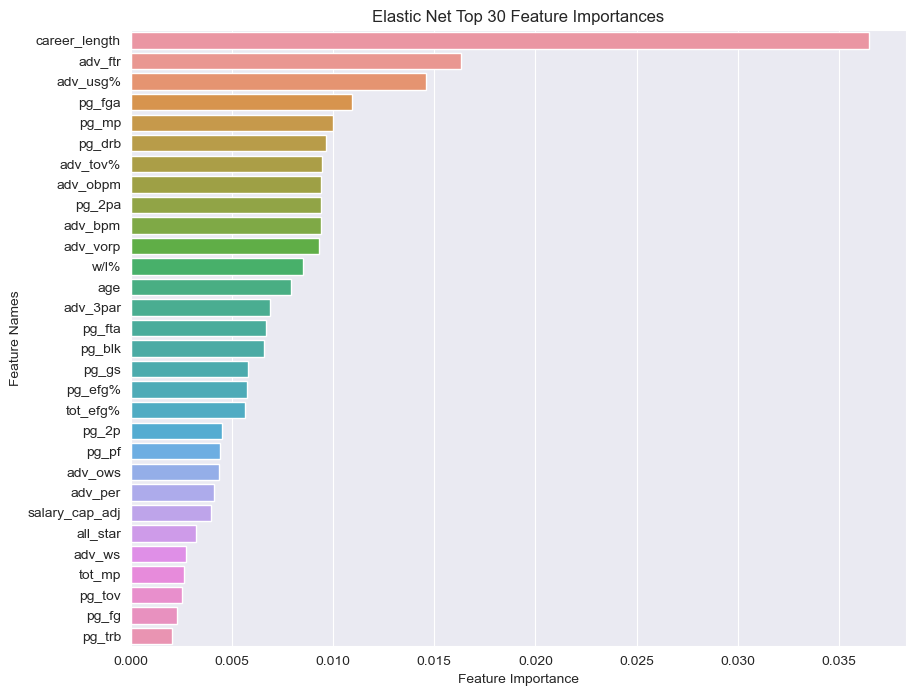

In [42]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=f12['feature_importance'], y=f12['feature_names'])
plt.title('Elastic Net Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

---
## VI. Random Forest Regressor

In [43]:
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=1527))
])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 1527,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [44]:
pgrid_rf =[
    {'rf__n_estimators': [250], #[150, 200, 250],
     'rf__max_depth': [50], #[50, 70, 90],
     'rf__max_features': [10], #[3, 6, 10]
    }]

In [45]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=10)
gs_rf.fit(X_train, y_train)

CPU times: total: 1.41 s
Wall time: 20.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'rf__max_depth': [50], 'rf__max_features': [10],
                          'rf__n_estimators': [250]}])

In [46]:
preds_rf = gs_rf.predict(X_test)

In [47]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_rf, squared=False),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9389 --------------------
------------------- Test: 0.6461 ---------------------
------------------- RMSE: 0.0605 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 10, 'rf__n_estimators': 250}


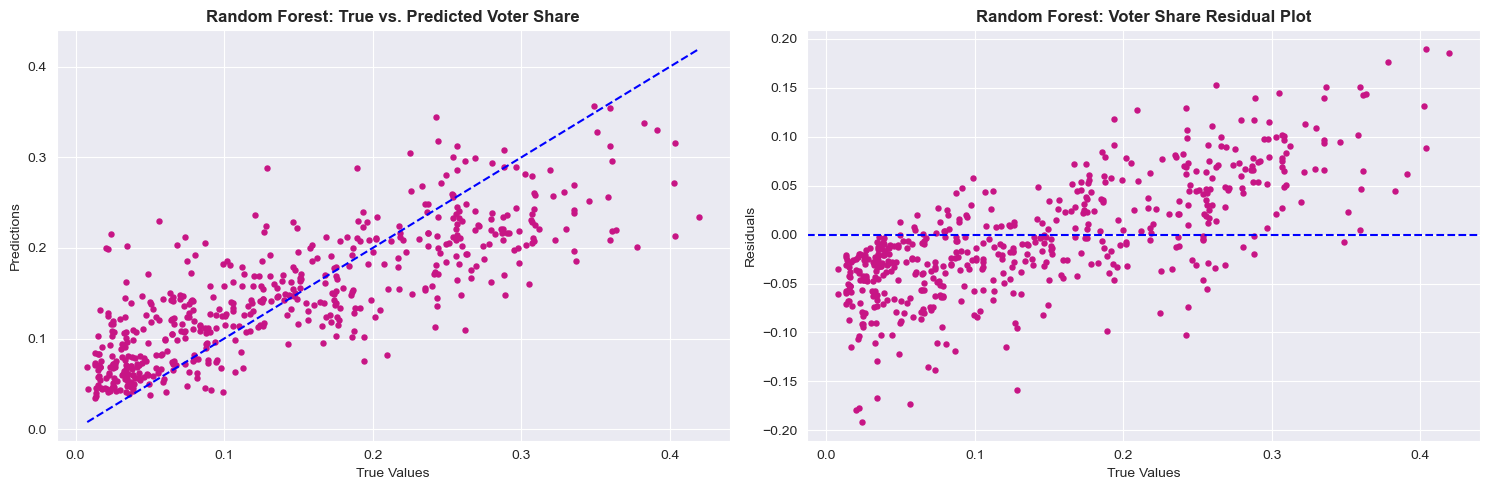

In [48]:
residplot('Random Forest', preds_rf)

In [49]:
best_estimator = gs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj' 'career_length']
[0.06643388 0.0085431  0.00817038 0.01068082 0.03324109 0.02137739
 0.00832813 0.00466733 0.00633612 0.00692113 0.02671797 0.02317959
 0.00785982 0.00820273 0.01156923 0.01652149 0.00979754 0.00785386
 0.02366928 0.01477096 0.00917663 0.0078425  0.01542734 0.01074797
 0.00787164 0.03093059 0.01089272 0.00781451 0.00624089 0.00654119
 0.00754326 0.00825408 0.0095

In [50]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

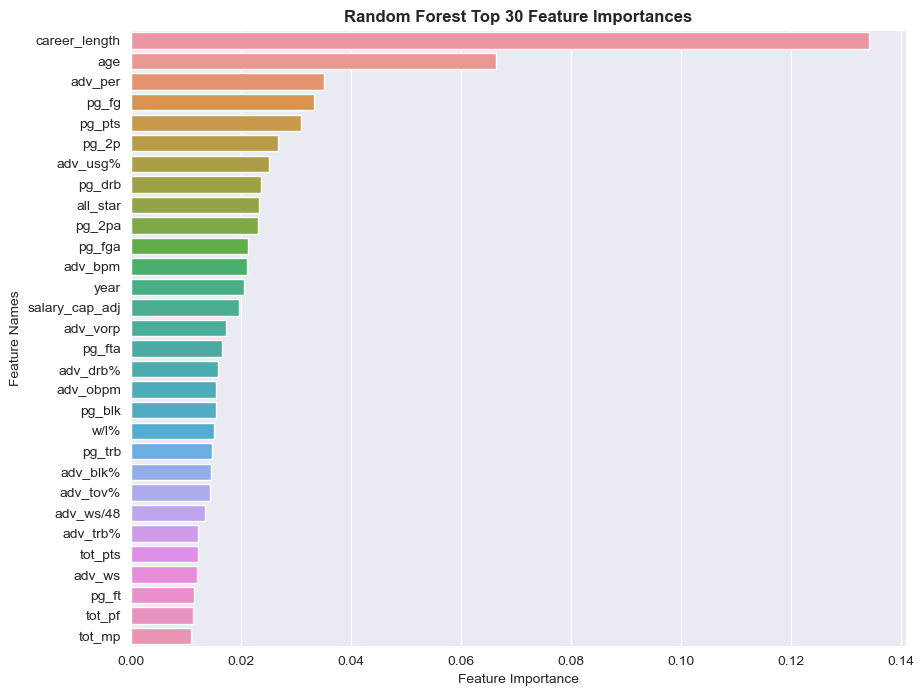

In [51]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); 

---
## VII. AdaBoost Regressor

In [52]:
pipe_ada = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('ada', AdaBoostRegressor(random_state=1527))
])

pipe_ada.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('ada', AdaBoostRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'ada': AdaBoostRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ada__base_estimator': 'deprecated',
 'ada__estimator': None,
 'ada__learning_rate': 1.0,
 'ada__loss': 'linear',
 'ada__n_estimators': 50,
 'ada__random_state': 1527}

In [53]:
pgrid_ada = [{
     'ada__n_estimators': [70], # [50, 70, 100]
     'ada__learning_rate': np.linspace(0.01, .5, 15)
    }]

In [54]:
%%time

gs_ada = GridSearchCV(pipe_ada, pgrid_ada, cv=5, n_jobs=5)
gs_ada.fit(X_train, y_train)

CPU times: total: 828 ms
Wall time: 59 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ada',
                                        AdaBoostRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'ada__learning_rate': array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
       0.325, 0.36 , 0.395, 0.43 , 0.465, 0.5  ]),
                          'ada__n_estimators': [70]}])

In [55]:
preds_ada = gs_ada.predict(X_test)

In [56]:
print(f'------------- {b1}AdaBoost w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_ada.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_ada.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_ada, squared=False),4)} --------------------')
print('Best Params:', gs_ada.best_params_)

------------- AdaBoost w/ GridSearch -------------
------------------- Train: 0.4983 -------------------
------------------- Test: 0.6046 --------------------
------------------- RMSE: 0.0639 --------------------
Best Params: {'ada__learning_rate': 0.045, 'ada__n_estimators': 70}


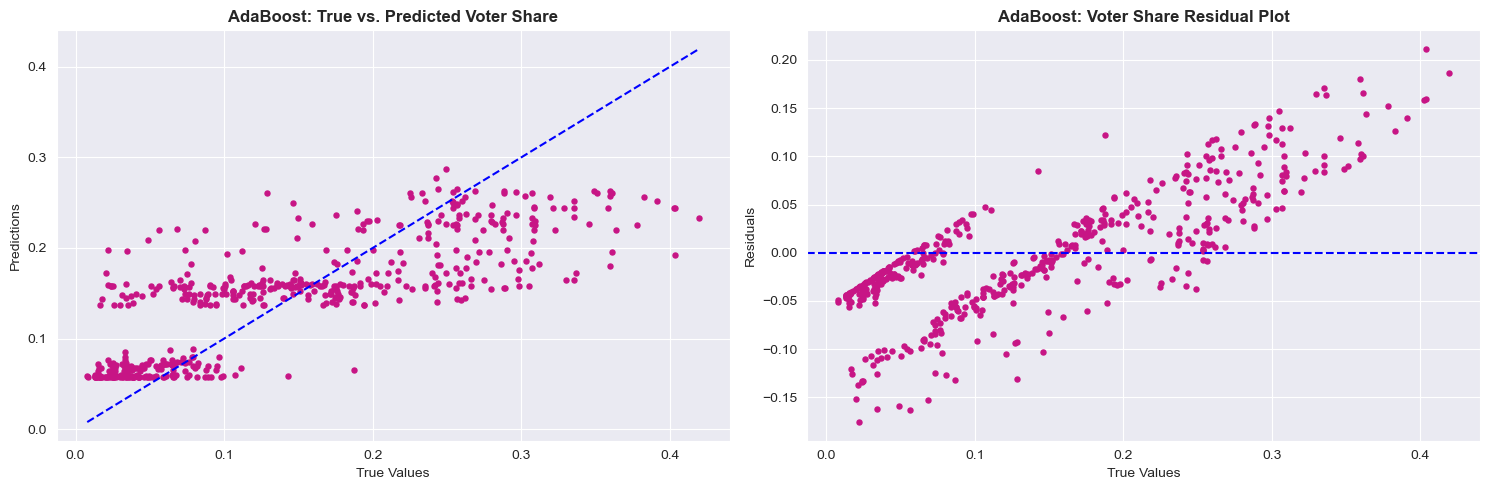

In [57]:
residplot('AdaBoost', preds_ada)

In [58]:
best_estimator = gs_ada.best_estimator_
adaboost = best_estimator.named_steps['ada']
feature_importances = adaboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj' 'career_length']
[2.18161081e-02 0.00000000e+00 0.00000000e+00 3.99680311e-03
 3.05640489e-02 3.68396845e-02 2.87388176e-07 1.56171216e-05
 0.00000000e+00 0.00000000e+00 1.39937686e-01 8.52609678e-02
 8.34032378e-04 0.00000000e+00 3.01265738e-04 4.86192009e-03
 0.00000000e+00 4.69224950e-04 3.73824135e-02 4.31547463e-03
 3.21532654e-07 7.73958461e-04 1.61600980e-02 5.97414212e-0

In [59]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

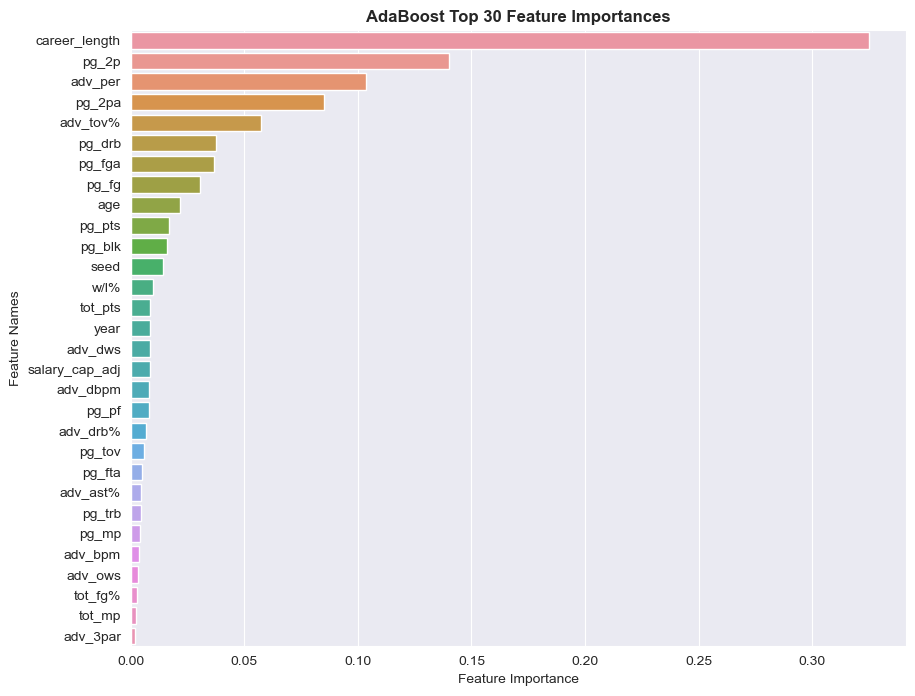

In [60]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('AdaBoost Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

# plt.savefig('../images/Feature_Importances_ada.png', dpi=192, bbox_inches='tight'); 

---
## VIII. XGBoost Regressor

In [61]:
pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('xgb', XGBRegressor(random_state=1527))
])

pipe_xgb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=1527, ...))],
 'verbose': False,
 'sc': StandardScaler(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [62]:
# pgrid_xgb = [{
    # 'xgb__n_estimators': [50, 75, 100, 200],
    # 'xgb__max_depth': [3,4,5,6],
    # 'xgb__learning_rate': np.linspace(0.01, .5, 10),
    # 'xgb__reg_alpha': np.linspace(0.01, .5, 10)  
  #  }]

pgrid_xgb = [{
     'xgb__n_estimators': [200],
     'xgb__max_depth': [3],
     'xgb__learning_rate': [0.06444444444444444],
     'xgb__reg_alpha': [0.44555555555555554],
    }]

In [63]:
%%time

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=10)
gs_xgb.fit(X_train, y_train)

CPU times: total: 4.06 s
Wall time: 13 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     in...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=1527, ...))]),
             n_jobs=10,
             param_grid=[{'xgb__learning_rate': [0.06444444444444444],
                          'xgb__max_depth': [3], 'xgb__n_estimators': [200],
                          'xgb__reg_alpha': [0.44555555555555554]}])

In [64]:
preds_xgb = gs_xgb.predict(X_test)

In [65]:
print(f'----------------- {b1}XGB w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_xgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_xgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_xgb, squared=False),4)} --------------------')
print('Best Params:', gs_xgb.best_params_)

----------------- XGB w/ GridSearch -----------------
------------------- Train: 0.7022 -------------------
------------------- Test: 0.6871 --------------------
------------------- RMSE: 0.0569 --------------------
Best Params: {'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.44555555555555554}


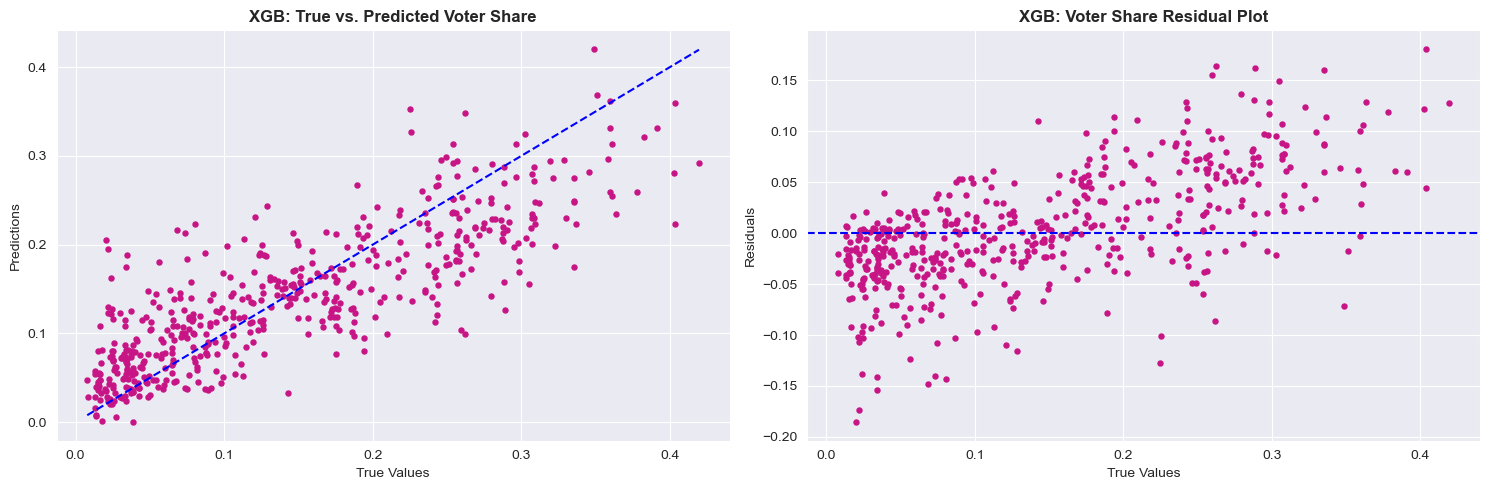

In [66]:
residplot('XGB', preds_xgb)

In [67]:
best_estimator = gs_xgb.best_estimator_
xgboost = best_estimator.named_steps['xgb']
feature_importances = xgboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj' 'career_length']
[0.00591995 0.00621798 0.00740364 0.02330383 0.01497761 0.02983561
 0.00458818 0.00463287 0.00065651 0.00449744 0.04587746 0.05442013
 0.00514256 0.00401504 0.0049362  0.02141866 0.00520769 0.00419985
 0.02925625 0.00876243 0.00921028 0.00295557 0.02891868 0.01366581
 0.00544992 0.04738736 0.00742867 0.         0.00322932 0.
 0.         0.         0.         0.0

In [68]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

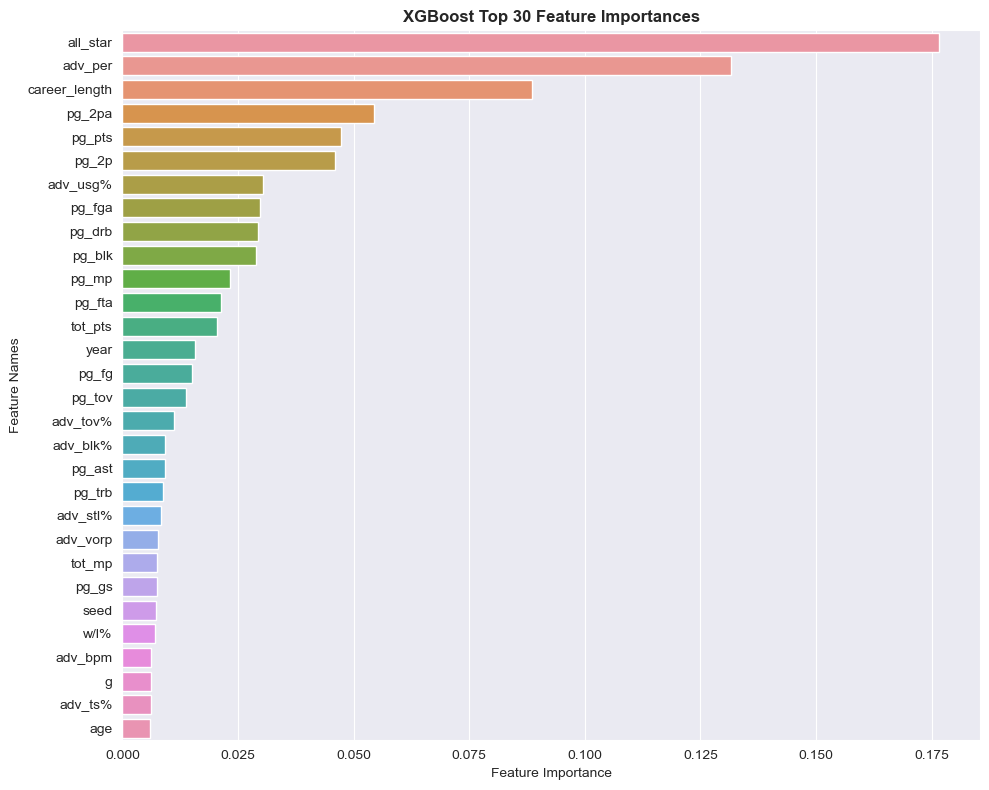

In [69]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('XGBoost Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.tight_layout()
plt.savefig('../images/Feature_Importances_xgb.png', dpi=192, bbox_inches='tight'); 
plt.show()

---
## IX. Light Gradient Boosting

In [70]:
pipe_lgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('lgb', LGBMRegressor(random_state=1527))
])

pipe_xgb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=1527, ...))],
 'verbose': False,
 'sc': StandardScaler(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [71]:
# pgrid_xgb = [{
    # 'xgb__n_estimators': [50, 75, 100, 200],
    # 'xgb__max_depth': [3,4,5,6],
    # 'xgb__learning_rate': np.linspace(0.01, .5, 10),
    # 'xgb__reg_alpha': np.linspace(0.01, .5, 10)  
  #  }]

pgrid_lgb = [{
     'lgb__learning_rate': np.linspace(0.01, .5, 15),
     'lgb__max_depth': [12],
     'lgb__n_estimators': [100],
     'lgb__num_leaves': [20],
    }]

In [72]:
%%time

gs_lgb = GridSearchCV(pipe_lgb, pgrid_lgb, cv=5, n_jobs=10)
gs_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 3573, number of used features: 65
[LightGBM] [Info] Start training from score 0.145488
CPU times: total: 1.03 s
Wall time: 25.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lgb',
                                        LGBMRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'lgb__learning_rate': array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
       0.325, 0.36 , 0.395, 0.43 , 0.465, 0.5  ]),
                          'lgb__max_depth': [12], 'lgb__n_estimators': [100],
                          'lgb__num_leaves': [20]}])

In [73]:
preds_lgb = gs_lgb.predict(X_test)

In [74]:
print(f'----------------- {b1}LGBM w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_lgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_lgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_lgb, squared=False),4)} --------------------')
print('Best Params:', gs_lgb.best_params_)

----------------- LGBM w/ GridSearch -----------------
------------------- Train: 0.7485 -------------------
------------------- Test: 0.6978 --------------------
------------------- RMSE: 0.0559 --------------------
Best Params: {'lgb__learning_rate': 0.045, 'lgb__max_depth': 12, 'lgb__n_estimators': 100, 'lgb__num_leaves': 20}


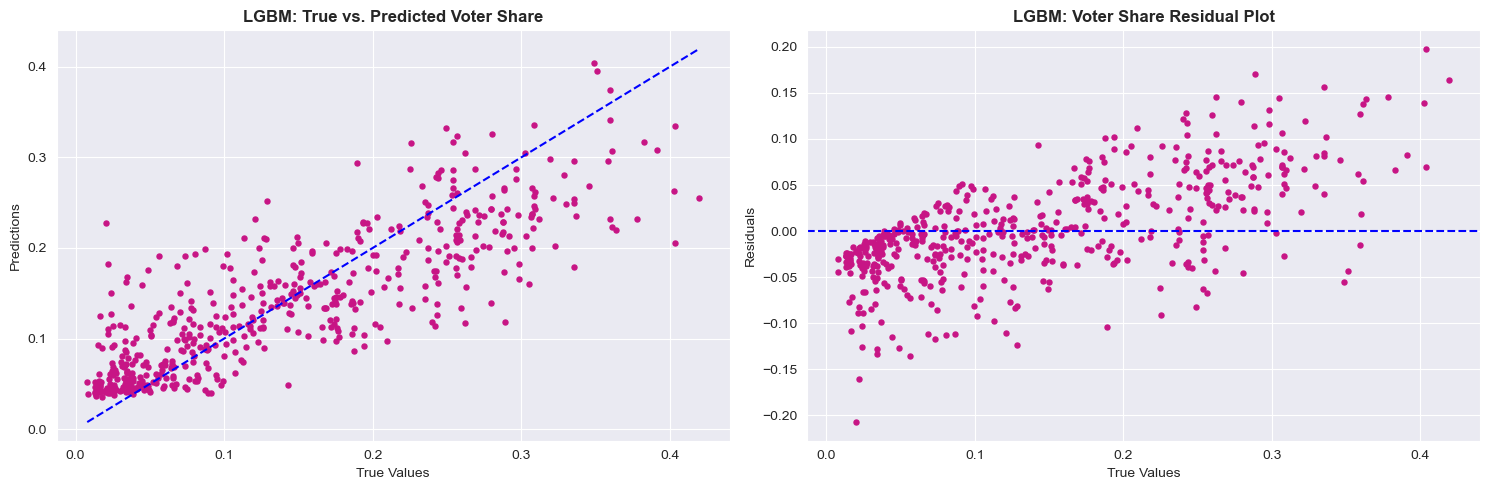

In [75]:
residplot('LGBM', preds_lgb)

In [76]:
best_estimator = gs_lgb.best_estimator_
lgboost = best_estimator.named_steps['lgb']
feature_importances = lgboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj' 'career_length']
[ 30  40  54  34  14  65  23   2   5  24  37  34  11  20  16  29  34   6
  55  18  15  18  67  52  23  43  29   0  14   0   0   0   0  29  20  31
  30  38  23  16  20  18  17  49  38  27  59  30  30  13  18  24  33  10
  18  32  28   6   0   7   2   6 177  29 210]


In [77]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

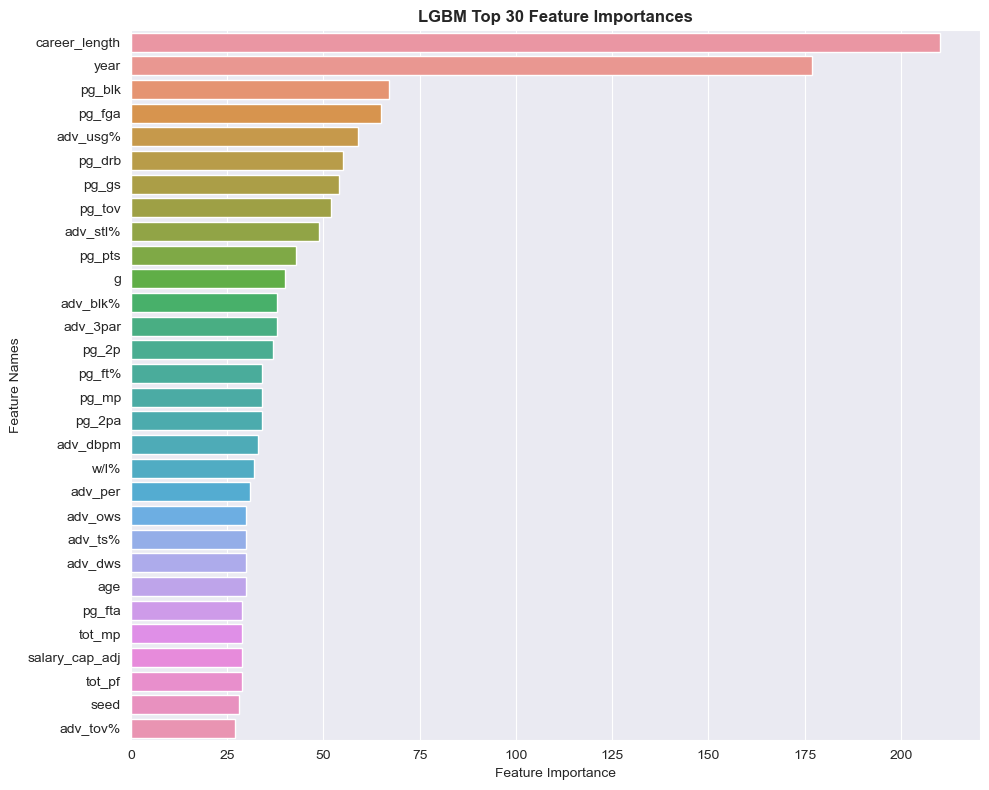

In [78]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('LGBM Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.tight_layout()
plt.savefig('../images/Feature_Importances_lgb.png', dpi=192, bbox_inches='tight'); 
plt.show()